# Data Cleaning and Pre-Processing

The purpose of this notebook is to show the data cleaning process and the exploratory data analysis. In this section, I want to make sense of the data and find any trends and anomalies in the data set.  

The text I will evaluate will be from the selftext column of the dataset. Null values for selftext will be dropped.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [2]:
df = pd.read_csv('./data/rideshare.csv')

Convert target into binary, Lyft is given a value of 1 and Uber 0

In [3]:
df['subreddit'] = (df['subreddit'] == 'Lyft')*1

In [4]:
df['subreddit'].value_counts()

1    3400
0    3400
Name: subreddit, dtype: int64

In [5]:
df.isna().sum()

created_utc       0
subreddit         0
selftext       2137
title             0
dtype: int64

Drop null values for selftext

In [6]:
df.dropna(inplace=True)

In [7]:
df['subreddit'].value_counts()

1    2332
0    2331
Name: subreddit, dtype: int64

In [8]:
df.shape

(4663, 4)

In [9]:
df.nunique()

created_utc    4660
subreddit         2
selftext       4263
title          4587
dtype: int64

In [10]:
df.drop_duplicates(inplace=True)

For the modeling process, the target variable has an equal distribution of uber and lyft subreddits.

In [11]:
df['subreddit'].value_counts()

1    2331
0    2329
Name: subreddit, dtype: int64

### Evaluating the word count for posts and titles

In [12]:
tokenizer = RegexpTokenizer('\s+', gaps=True)
df['title_word_count'] = [len(tokenizer.tokenize(i)) for i in df['title']]

In [13]:
#split tokens up by spaces
tokenizer2 = RegexpTokenizer('\s+', gaps=True)
df['selftext_word_count'] = [len(tokenizer2.tokenize(i)) for i in df['selftext']]

In [14]:
df.to_csv('data/rideshare_v2.csv', index=False)

In [15]:
df.describe()

,created_utc,subreddit,title_word_count,selftext_word_count
count,4.660000e+03,4660.000000,4660.000000,4660.000000
mean,1.565563e+09,0.500215,8.712661,97.821888
std,2.965036e+07,0.500054,6.724650,129.970981
min,1.516068e+09,0.000000,1.000000,1.000000
25%,1.540364e+09,0.000000,4.000000,30.000000
50%,1.564795e+09,1.000000,7.000000,65.000000
75%,1.591103e+09,1.000000,11.000000,120.000000
max,1.615886e+09,1.000000,58.000000,2830.000000


In [16]:
df.groupby('subreddit')['selftext_word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,2329.0,96.756977,130.182347,1.0,28.0,65.0,123.0,2830.0
1,2331.0,98.885886,129.778655,1.0,32.0,65.0,117.0,2344.0


In [17]:
df.groupby('subreddit')['title_word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,2329.0,9.035638,7.006135,1.0,4.0,7.0,11.0,56.0
1,2331.0,8.389961,6.416399,1.0,4.0,7.0,11.0,58.0


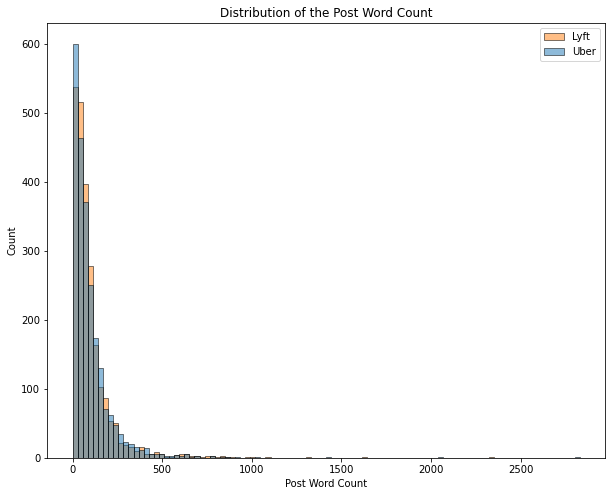

In [18]:
plt.figure(figsize=(10,8))
sns.histplot(data=df, x = 'selftext_word_count', hue = 'subreddit', legend=True, bins = 100)
plt.legend(labels = ['Lyft','Uber'])
plt.xlabel('Post Word Count')
plt.title('Distribution of the Post Word Count')
plt.show()

The distribution of the post word counts are similar between the Lyft and Uber posts.

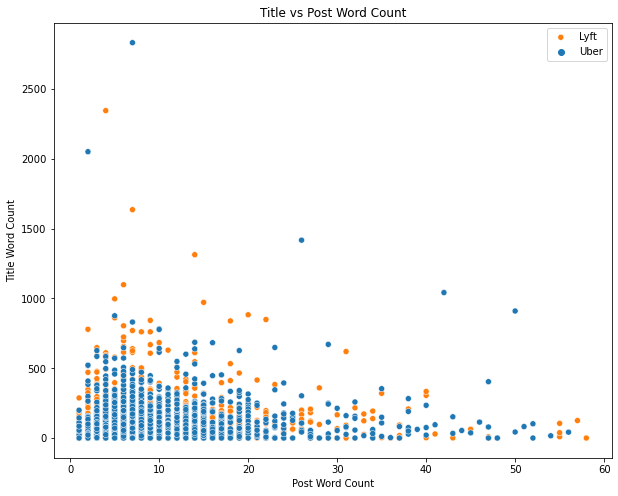

In [19]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x = 'title_word_count', y ='selftext_word_count', hue = 'subreddit', legend=True)
plt.legend(labels = ['Lyft','Uber'])
plt.xlabel('Post Word Count')
plt.ylabel('Title Word Count')
plt.title('Title vs Post Word Count')
plt.show()

No major trends noted in the scatterplot between post word count and title word count. Lyft and Uber share a similar distribution of data.

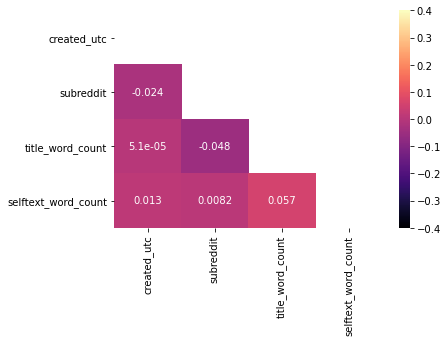

In [20]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, vmin=-.4, vmax=.4, cmap='magma', annot=True);

There was no major correlation of note.

### Initial Statistical Analysis  

In this section, I explored the top words for each subreddit. As expected, the top words for each subreddit was "uber" and "lyft". I kept these words since the goal of this project was to create a model that can accurately classify whether a post came from the Uber or Lyft subreddit.

In [21]:
uber = df[df['subreddit'] == 0]
lyft = df[df['subreddit'] == 1]

X_uber = uber['title']
X_lyft = lyft['title']
# Instantiate a CountVectorizer.
cvec = CountVectorizer(stop_words='english')
cvec2 = CountVectorizer(stop_words='english')
X_ucv = cvec.fit_transform(X_uber)

X_lcv = cvec2.fit_transform(X_lyft)

In [22]:
uber_cv = pd.DataFrame(X_ucv.todense(), columns = cvec.get_feature_names())
lyft_cv = pd.DataFrame(X_lcv.todense(), columns = cvec2.get_feature_names())

In [23]:
uber_cv.sum().sort_values(ascending=False).head(15)

uber        1184
driver       326
drivers      184
ride         182
account      118
question      96
help          87
eats          80
app           77
card          72
car           71
charged       70
new           69
trip          66
rides         66
dtype: int64

In [24]:
lyft_cv.sum().sort_values(ascending=False).head(15)

lyft         864
driver       309
ride         214
drivers      202
question     101
car           89
rides         88
driving       86
new           84
drive         75
app           71
passenger     70
time          66
uber          58
pax           56
dtype: int64

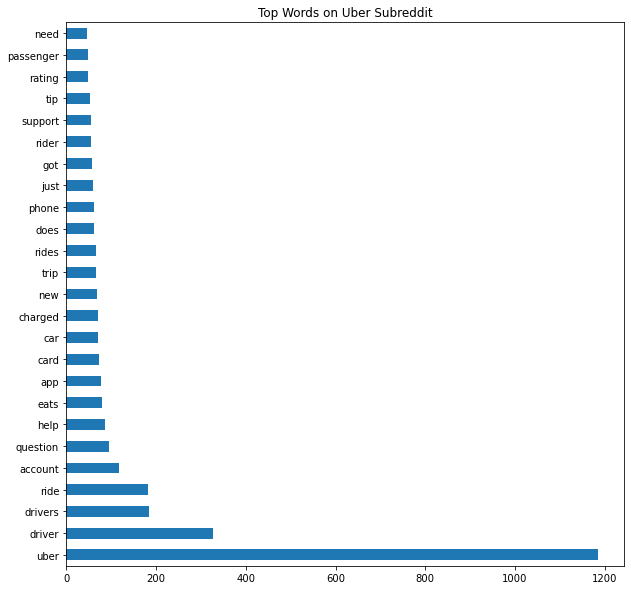

In [25]:
plt.figure(figsize=(10,10))
uber_cv.sum().sort_values(ascending=False).head(25).plot(kind='barh')
plt.title('Top Words on Uber Subreddit');

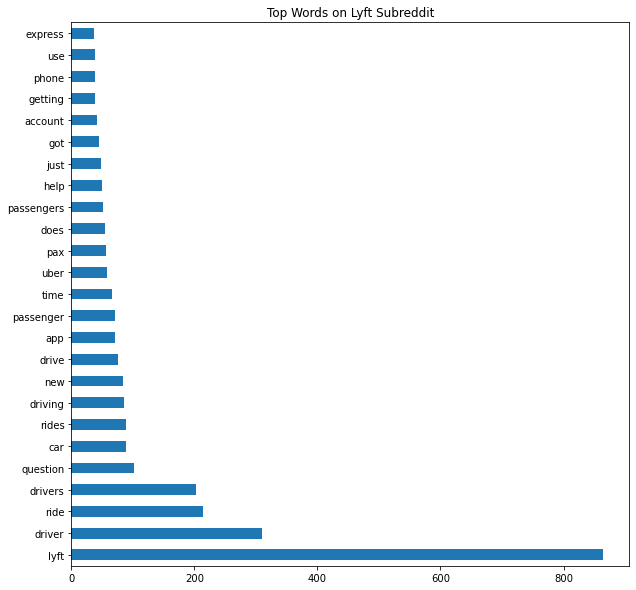

In [26]:
plt.figure(figsize=(10,10))
lyft_cv.sum().sort_values(ascending=False).head(25).plot(kind='barh')
plt.title('Top Words on Lyft Subreddit');

### Sentiment Intensity Analyzer  

In this section, I analyzed the sentiment for each post in the dataset. Both Lyft and Uber datasets shared the same distribution of sentiment compound scores. Lyft had a slightly higher compound mean score of 0.079 while Uber had a compound mean score of 0.060.

In [27]:
sentiment = SentimentIntensityAnalyzer()

In [28]:
df['sentiment'] = df['selftext'].apply(lambda x: sentiment.polarity_scores(x)['compound'])

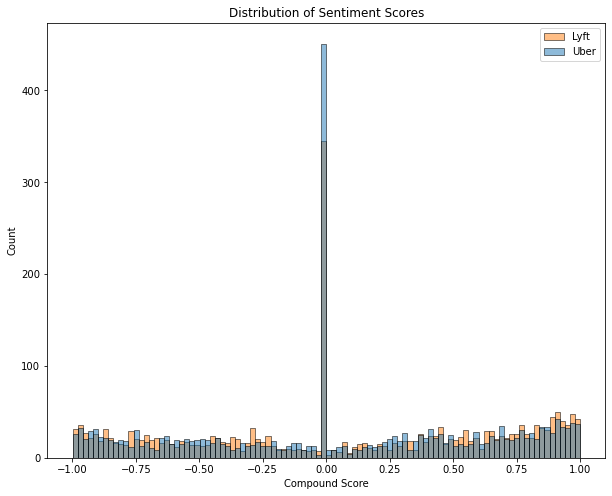

In [29]:
plt.figure(figsize=(10,8))
sns.histplot(data=df, x = 'sentiment', hue = 'subreddit', legend=True, bins = 100)
plt.legend(labels = ['Lyft','Uber'])
plt.xlabel('Compound Score')
plt.title('Distribution of Sentiment Scores')
plt.show()

In [30]:
df[df['subreddit'] == 1]['sentiment'].describe()

count    2331.000000
mean        0.079354
std         0.607291
min        -0.998500
25%        -0.421500
50%         0.000000
75%         0.647050
max         0.996900
Name: sentiment, dtype: float64

In [31]:
df[df['subreddit'] == 0]['sentiment'].describe()

count    2329.000000
mean        0.060851
std         0.579733
min        -0.996700
25%        -0.413100
50%         0.000000
75%         0.571900
max         0.999500
Name: sentiment, dtype: float64